In [19]:
import pandas as pd
import numpy as np
from scipy.linalg import hankel
from numpy.linalg import svd
import matplotlib.pyplot as plt

# CDS Spread Citi Data


In [20]:
# Read citi_cds_spread .csv
df = pd.read_csv('citi_cds_monthly.csv', parse_dates=['Date'], index_col='Date')

In [27]:
# embedding dimension (window size for Hankel matrix)
L = 12  

# Function to create a Hankel matrix from a time series
def create_hankel_matrix(series, L):
    """Creates a Hankel (trajectory) matrix from a time series."""
    N = len(series)
    if N < L:
        raise ValueError("Time series too short for chosen window size L.")
    
    return np.column_stack([series[i:N-L+i+1] for i in range(L)])

#  MSSA trajectory matrix
hankel_matrices = []
valid_columns = []

for column in df.columns:
    if df[column].isna().sum() < len(df) - L:  
        hankel_matrix = create_hankel_matrix(df[column].dropna().values, L)
        hankel_matrices.append(hankel_matrix)
        valid_columns.append(column)

# Stack Hankel matrices vertically to form the MSSA input matrix
MSSA_matrix = np.vstack(hankel_matrices)

# Display matrix dimensions
print(f"MSSA Matrix Shape: {MSSA_matrix.shape} (rows: {MSSA_matrix.shape[0]}, cols: {MSSA_matrix.shape[1]})")
np.save("mssa_trajectory_matrix.npy", MSSA_matrix)
print("First 5 rows of MSSA Trajectory Matrix:")
print(MSSA_matrix[:5, :5]) 

MSSA Matrix Shape: (2295, 12) (rows: 2295, cols: 12)
First 5 rows of MSSA Trajectory Matrix:
[[25.4459 24.6774 23.1773 23.7423 24.9804]
 [24.6774 23.1773 23.7423 24.9804 21.0954]
 [23.1773 23.7423 24.9804 21.0954 21.8762]
 [23.7423 24.9804 21.0954 21.8762 23.1877]
 [24.9804 21.0954 21.8762 23.1877 21.3936]]


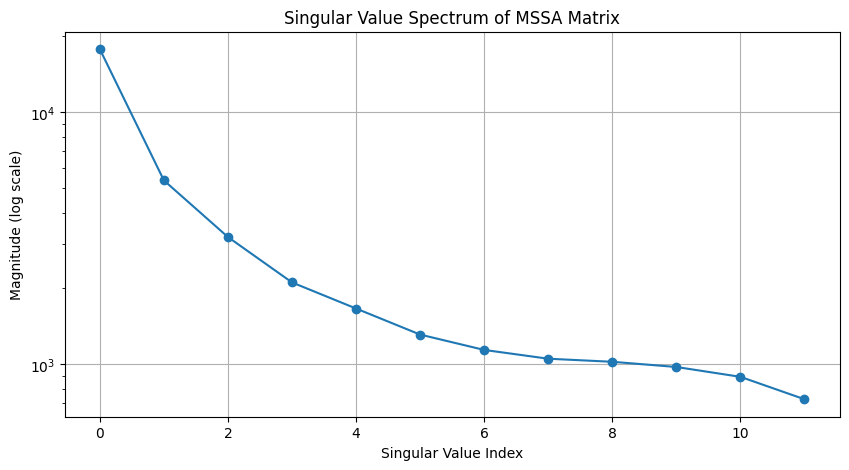

In [22]:
MSSA_matrix = np.load("mssa_trajectory_matrix.npy")

# Perform Singular Value Decomposition (SVD)
U, Sigma, Vt = svd(MSSA_matrix, full_matrices=False)

# Save results for later use
np.save("U_matrix.npy", U)
np.save("Sigma_values.npy", Sigma)
np.save("Vt_matrix.npy", Vt)

# Plot singular values (log scale) to identify signal vs. noise
plt.figure(figsize=(10, 5))
plt.semilogy(Sigma, marker="o", linestyle="-")
plt.title("Singular Value Spectrum of MSSA Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Magnitude (log scale)")
plt.grid()
plt.show()

1. Singular Value Spectrum of the MSSA (Multivariate Singular Spectrum Analysis) Matrix, which represents the magnitude of singular values derived from the Singular Value Decomposition (SVD) of the MSSA trajectory matrix
2. Steep Drop at the Beginning: The first few singular values are much larger, meaning they capture the main structure and trends in the CDS spreads
3. Gradual Decline: As you move towards higher indices, the singular values decrease, meaning these components contribute less to the overall structure
4. Flatter Region (Tail End): The smallest singular values likely capture noise, making them less useful for hole-filling and forecasting

## 
A=UΣV^T

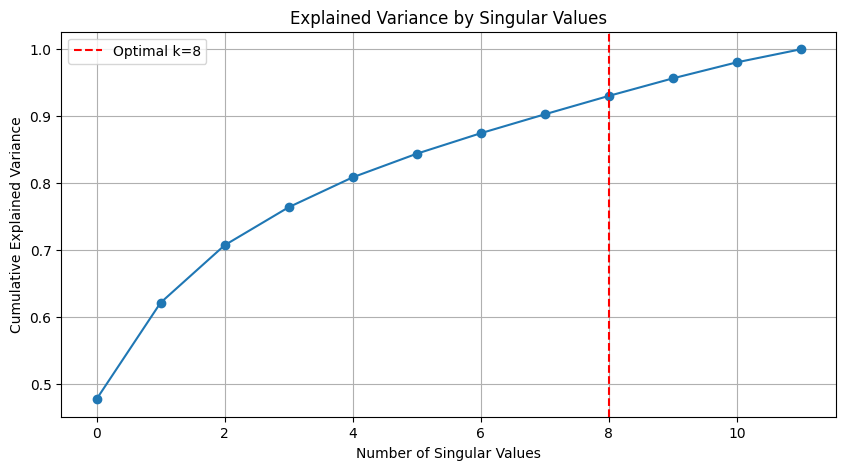

Reconstructed MSSA Matrix Shape: (2295, 12)
First 5 rows of the reconstructed MSSA Matrix:
[[25.43701315 24.04993878 24.60000203 23.21399792 23.60745043]
 [23.7343788  24.56399667 23.81463872 23.62125528 22.21629887]
 [23.57022084 23.53354062 24.08041076 22.18322813 22.08036606]
 [23.55905127 24.58227796 22.65820051 20.79494236 22.38290181]
 [23.4503408  22.98057663 22.73958029 20.99157462 22.57778763]]


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Load SVD components
U = np.load("U_matrix.npy")
Sigma = np.load("Sigma_values.npy")
Vt = np.load("Vt_matrix.npy")

# Determine the number of singular values to keep (retain 90% of variance)
explained_variance = np.cumsum(Sigma) / np.sum(Sigma)
k_optimal = np.argmax(explained_variance >= 0.90) + 1  # Minimum k for 90% variance

# Plot explained variance to visualize the cutoff
plt.figure(figsize=(10, 5))
plt.plot(explained_variance, marker="o", linestyle="-")
plt.axvline(k_optimal, color="r", linestyle="--", label=f"Optimal k={k_optimal}")
plt.title("Explained Variance by Singular Values")
plt.xlabel("Number of Singular Values")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

# Reconstruct MSSA matrix using top k singular values
U_k = U[:, :k_optimal]
Sigma_k = np.diag(Sigma[:k_optimal])
Vt_k = Vt[:k_optimal, :]

# Reconstructed MSSA matrix
MSSA_reconstructed = np.dot(U_k, np.dot(Sigma_k, Vt_k))

np.save("mssa_reconstructed.npy", MSSA_reconstructed)
print(f"Reconstructed MSSA Matrix Shape: {MSSA_reconstructed.shape}")
print("First 5 rows of the reconstructed MSSA Matrix:")
print(MSSA_reconstructed[:5, :5])